# Changing gain and thalamocortical weight for individual connections

In [1]:
%pylab nbagg
from tvb.simulator.lab import *
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
import numpy as np
import matplotlib.pyplot as plta
import tvb.analyzers.correlation_coefficient as corr_coeff
from tvb.datatypes.time_series import TimeSeriesRegion
import time

# to get an estimate of simulation time use: tic=time.time()
#tic-time.time() 
# Bezgin 2017 Human Brain Mapping for information on the 96 parcellation

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


# Saving the SC matrix

In [2]:
conn=connectivity.Connectivity.from_file('connectivity_96.zip')
data_struct=conn.weights;
import scipy.io as sio
sio.savemat('/Users/RChenLab/Documents/TVB_Distribution/demo_scripts/Github/ThalCorProject/Struct_data.mat',{'data_struct':data_struct})
Labels=conn.region_labels
sio.savemat('/Users/RChenLab/Documents/TVB_Distribution/demo_scripts/Github/ThalCorProject/Region_labels.mat',{'Label':Labels})
Labels[91]

# 41- Right frontal
# 42- Right temporal
# 43- Right Occipitoparietal

# 89- Left frontal
# 90- Left temporal
# 91- Left Occipitoparietal

WARNING  File 'hemispheres' not found in ZIP.


'TM-OP_L'

# Building the model

In [3]:
def run_sim(conn, gain, D, dt=0.5, simlen=1e3):
    """
    Run a single instance of the simulation.
    Returns a list of pairs (times, values). There will be one entry
    in the list for each output monitor used.
    """
    mon_raw = monitors.Raw()
    mon_tavg = monitors.TemporalAverage(period=5.0)#period=2**-2)
    #Bundle them
    what_to_watch = (mon_tavg, mon_raw)
    
    
    sim = simulator.Simulator(
        
        model=models.Generic2dOscillator(a=0.0),
        # Change the Conn matrix here; make it twice as large three times as large
        connectivity=conn,  # use the connectivity structure defined below
        #coupling=coupling.PreSigmoidal(H=gain,theta=0.0,dynamic=False), # parameters?
        coupling=coupling.Linear(a=gain),
        integrator=integrators.HeunStochastic(dt=dt,
                           noise=noise.Additive(nsig=np.array([D]))),
        monitors = what_to_watch
    )
    sim.configure()
    
    #Perform the simulation
    res = sim.run(simulation_length=simlen)
    (tavg_time,tavg_dat),(raw_time,raw_dat) = res
    
    return sim,tavg_time,tavg_dat,raw_time,raw_dat


In [4]:
# Run the simulation

# using the gain parameter specified on the command line,
# run one instance of the simulation
# the label is there simply to allow running multiple of these in parallel
# without clobbering each other's output files
burnin=500
d = {}
w=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2.0]
g=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]
raw_show={}
tic=time.time()
for i in range(len(g)):
    for j in range(len(w)):
        conn=connectivity.Connectivity.from_file('connectivity_96.zip')
        # thalamocortical connections
        #conn.weights[[41, 42, 43, 89, 90, 91],:] = conn.weights[[41, 42, 43, 89, 90, 91],:]*w[j]
        # individual thalamocortical connections
        conn.weights[[43,91],:] = conn.weights[[43,91],:]*w[j]
        conn.weights[:, [43,91]] = conn.weights[:, [43,91]]*w[j]
        # Some random connections from a uniform distribution
        #conn.weights[[1, 5, 10, 20, 30, 50],:] = conn.weights[[1, 5, 10, 20, 30, 50],:]*w[j]
        #conn.weights[:,Rand[Index,:]] = conn.weights[:, Rand[Index,:]]*w[j]
        conn.configure()
        sim,tavg_time,tavg_dat,raw_time,raw_dat = run_sim(conn, g[i], 5e-4, simlen=1e3)
        # reshape the data which are output with some empty dimensions
        raw_timep=raw_time[burnin:,]
        raw = raw_dat
        # calculate global variance
        raw = raw[:,0,:,0]
        simdata=raw[burnin:,:] # remove the burnin period
        g[i]=round(g[i],2)
        VAR=np.var(simdata)
        d[g[i],w[j]] = VAR
        raw_show[g[i],w[j]]=raw_dat[burnin:,:,:,:]
'simulation required %0.3f seconds.' % (time.time() - tic, )
print(d)
print(simdata.shape)

WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'hemispheres' not fo

In [ ]:
# now plot as a function of gain
#figure()
#plt.bar(range(len(g)), d.values(), align='center')
#plt.xticks(range(len(d)), d.keys())
#show()

In [5]:
RAW=raw_show[0.4,0.8]
X=RAW[:,0,:,0]
RAW.shape

(1500, 1, 96, 1)

# Visualize time-series

<IPython.core.display.Javascript object>


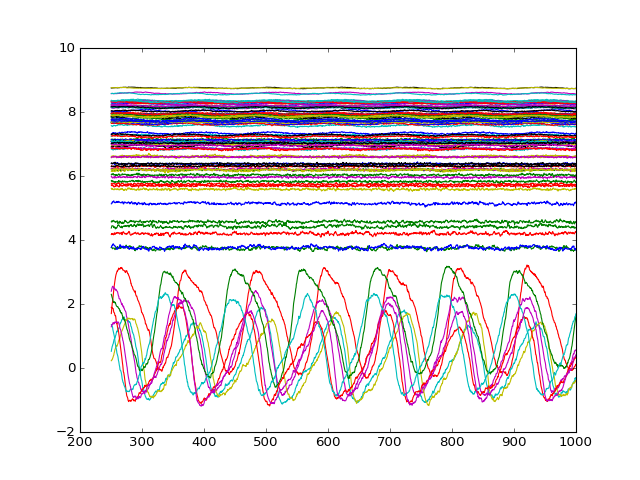

In [7]:
# choose data for which coupling you want to visualize (show time series) and compute correlation coefficient
RAW=raw_show[0.4,0.2]
figure()
plot(raw_timep, RAW[:,0,:,0])
show()

# Compute connectivity

In [8]:
def compare_con(gain,Weight,RAW):
    data_show=RAW[gain,Weight]
    # compute functional connectivity using analyzer
    tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                           data=data_show,
                           sample_period=sim.monitors[0].period)
    tsr.configure()
    corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
    corrcoeff_data = corrcoeff_analyser.evaluate()
    corrcoeff_data.configure()
    FC = corrcoeff_data.array_data[..., 0, 0]
    # plot
    #figure(figsize=(10, 4))
    conn=connectivity.Connectivity.from_file('connectivity_96.zip')
    #subplot(121), imshow(conn.weights, cmap='binary', interpolation='none')
    #subplot(122), imshow(FC, cmap='binary', interpolation='none');
    import scipy.io as sio
    sio.savemat('/Users/RChenLab/Documents/TVB_Distribution/demo_scripts/Github/ThalCorProject/FC_LoopOP'+str(gain)+'Weight'+str(Weight)+'.mat',{'data_struct':FC})
    # save raw data
    Data_sq=data_show[:,0,:,0]
    sio.savemat('/Users/RChenLab/Documents/TVB_Distribution/demo_scripts/Github/ThalCorProject/FC_LoopOPRaw'+str(gain)+'Weight'+str(Weight)+'.mat',{'data_struct':Data_sq})
    #plt.colorbar()
    #show()
    return data_show

In [9]:
for i in range(len(g)):
    for j in range(len(w)):
        data_show=compare_con(g[i],w[j],raw_show)
        
#data_show=compare_con(0.8,1.5,raw_show)
#data_show.shape

data_reshaped=data_show[:,0,:,0]


   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not fo

WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.
   INFO  result shape will be: (96, 96, 1, 1)
WARNING  File 'hemispheres' not found in ZIP.


In [ ]:
Random=np.array([[79,80,13,3,7,32], [2,13,50,3,7,13],[7,13,92,51,51,51],[50,44,3,50,51,44],[44,61,49,32,82,79]])
Random[0,:]

In [ ]:
#Figure()
#plot_tri_matrix(sim.connectivity.weights,
#                cmap=pyplot.cm.RdYlBu_r, 
#                node_labels= sim.connectivity.region_labels,
#                size=[10., 10.],
#                color_anchor=(-1.0, 1.0));
#show()